In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

In [2]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>
# set table border

### (1) Import data

In [3]:
df = pd.read_csv(r'./data/OD_2018-04.csv') # use . to specify the parent folder of this script
station = pd.read_csv(r'./data/Stations_2018.csv')

### (2) Let's explore the trip data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236982 entries, 0 to 236981
Data columns (total 6 columns):
start_date            236982 non-null object
start_station_code    236982 non-null int64
end_date              236982 non-null object
end_station_code      236982 non-null int64
duration_sec          236982 non-null int64
is_member             236982 non-null int64
dtypes: int64(4), object(2)
memory usage: 10.8+ MB


In [5]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['start_hour'] = df['start_date'].apply(lambda x:x.hour)
df.head()

,start_date,start_station_code,end_date,end_station_code,duration_sec,is_member,start_hour
0,2018-04-10 11:56:00,7030,2018-04-10 11:57,6141,87,1,11
1,2018-04-10 11:56:00,6100,2018-04-10 11:59,6064,122,1,11
2,2018-04-10 11:57:00,6730,2018-04-10 12:16,6396,1132,1,11
3,2018-04-10 11:58:00,6108,2018-04-10 12:02,6114,271,1,11
4,2018-04-10 12:01:00,6223,2018-04-10 12:10,6233,513,1,12


Text(0.5, 1.0, '2018/04')

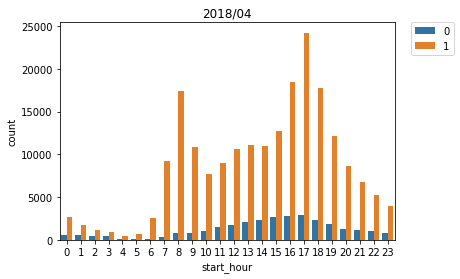

In [6]:
data = df['start_hour']
hue = df['is_member']
sns.countplot(data, hue=hue)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('2018/04')

Legend: "1" represents **member**, "0" represents **non-member**.

The above is a count plot for number of trips starting for each hour of a day. Interestingly, the distribution for members has a bimodal shape, which is different for non-members. This somehow indicates that if you are a member, you are likely using BIXI for work-commute purpose, which is shown by the two peaks at 8hr and 17hr. This trend is not present in non-members.

count    236982.000000
mean        732.055034
std         580.180470
min          61.000000
25%         325.000000
50%         565.000000
75%         979.000000
max        7189.000000
Name: duration_sec, dtype: float64

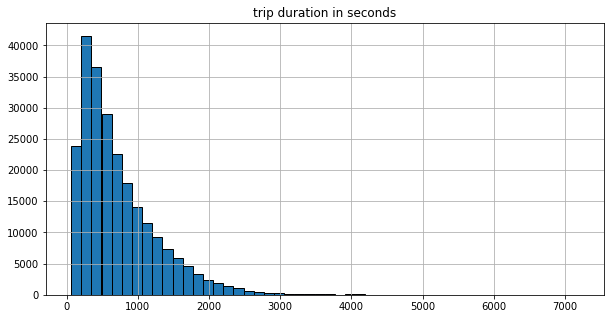

In [7]:
# information on trip duration in seconds
df['duration_sec'].hist(bins=50, figsize=(10,5), edgecolor='black')
plt.title('trip duration in seconds')
df['duration_sec'].describe()

The average duration of a trip is around 12.2 minutes (732 seconds).

### (3) Now let's add the station data into the mix

In [8]:
station.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 552 entries, 0 to 551
Data columns (total 4 columns):
code         552 non-null int64
name         552 non-null object
latitude     552 non-null float64
longitude    552 non-null float64
dtypes: float64(2), int64(1), object(1)
memory usage: 17.3+ KB


In [9]:
station.head()

,code,name,latitude,longitude
0,7030,de Bordeaux / Marie-Anne,45.533409,-73.570657
1,6141,de Bordeaux / Rachel,45.532270,-73.568280
2,6100,Mackay / de Maisonneuve,45.496590,-73.578510
3,6064,Métro Peel (de Maisonneuve / Stanley),45.500380,-73.575070
4,6730,35e avenue / Beaubien,45.570081,-73.573047


In [10]:
def look_up(station_code):
# this function finds the number of counts in df['start_station_code'] for a station_code, if not found, return 0
    if station_code in df['start_station_code'].tolist():
        count = df[df['start_station_code']==station_code]['start_station_code'].value_counts().tolist()[0]
        return count
    else:
        return 0

look_up(6100)

2560

In [11]:
station['start_freq'] = station['code'].apply(lambda x:look_up(x))
station.head()

,code,name,latitude,longitude,start_freq
0,7030,de Bordeaux / Marie-Anne,45.533409,-73.570657,314
1,6141,de Bordeaux / Rachel,45.532270,-73.568280,542
2,6100,Mackay / de Maisonneuve,45.496590,-73.578510,2560
3,6064,Métro Peel (de Maisonneuve / Stanley),45.500380,-73.575070,1746
4,6730,35e avenue / Beaubien,45.570081,-73.573047,88


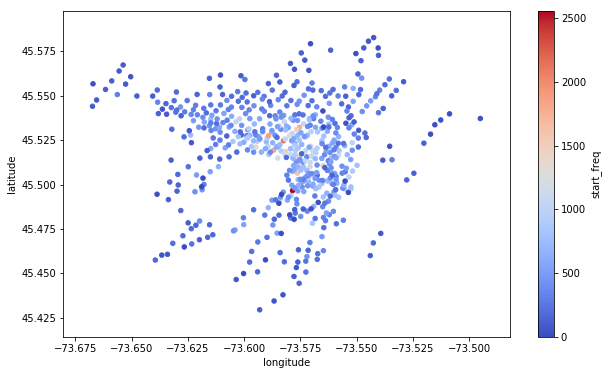

In [12]:
# plot the frequency of start on top of geographic locations of all stations
fig, ax = plt.subplots()
station.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,6), c='start_freq', cmap=plt.get_cmap("coolwarm"), ax=ax )

The above is a scatter plot showing the geographic location of all stations. Each dot represents one station. The color of the dot represents the total number of trips that have been started from this station.

What are the geographic locations of these most popolar stations for starting a trip? The table below gives the answer.

In [13]:
# information on the 5 most frequently used station for starting a trip
station.nlargest(5, 'start_freq')

,code,name,latitude,longitude,start_freq
2,6100,Mackay / de Maisonneuve,45.496590,-73.578510,2560
35,6184,Métro Mont-Royal (Rivard / du Mont-Royal),45.524673,-73.582550,2151
485,6136,Métro Laurier (Rivard / Laurier),45.527616,-73.589115,1879
124,6221,du Mont-Royal / Clark,45.519410,-73.586850,1837
53,6154,Marquette / du Mont-Royal,45.532290,-73.575440,1771


The main observation I get is that the BIXI stations in the plateau area of Montreal (near subway station Mont-Royal and Laurier) are used very frequently for starting a trip, however, the most popular station is located in downtown montreal (code 6100, Mackay / de Maisonneuve).